In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [3]:
from util import show, plot_images, plot_tensors

In [4]:
from torchvision import transforms
from torch.utils.data import Dataset
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as data
import torchvision
from torchvision import transforms
from skimage.measure import compare_psnr

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


EPOCHS = 2
BATCH_SIZE = 20
LEARNING_RATE = 0.003
TRAIN_DATA_PATH = "./Confocal_BPAE_B/raw"
GT_DATA_PATH = "./Confocal_BPAE_B/gt"
TRANSFORM_IMG = transforms.Compose([
    transforms.CenterCrop(128),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
    
    ])
train_data = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, transform=TRANSFORM_IMG)
gt_data = torchvision.datasets.ImageFolder(root=GT_DATA_PATH, transform=TRANSFORM_IMG)


In [5]:
dataset1 = train_data
dataset2 = gt_data


class gtmatch(Dataset):
    def __init__(self, dataset1, dataset2, batch_size):
        self.dataset1 = dataset1
        self.dataset2 = dataset2
        
    def __getitem__(self, index):
        x = self.dataset1[index][0]
        y= self.dataset2[int(index/batch_size % batch_size)][0]
        return x, y
    
    def __len__(self):
        return len(self.dataset1)

newdataset = gtmatch(dataset1, dataset2, 50)

In [6]:
batch_size=50
from torch import randn
def add_noise(img):
    return img + randn(img.size())*0.01

class SyntheticNoiseDataset(Dataset):
    def __init__(self, data, mode='train'):
        self.mode = mode
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img = self.data[index][0]
        return add_noise(img), img



In [7]:
newdataset = SyntheticNoiseDataset(newdataset, 'train')

In [8]:
from models.RIM import RIM
from models.babyunet import BabyUnet

model = RIM()
model2=BabyUnet()

In [9]:
from torch.nn import MSELoss
from torch.optim import Adam
from torch.utils.data import DataLoader
import logging 
loss_function = MSELoss()
optimizer = Adam(model.parameters(), lr=0.002)

In [10]:
from torch.utils.data.sampler import SequentialSampler
validation_split = .2
shuffle_dataset = False
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(newdataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SequentialSampler(train_indices)
valid_sampler = SequentialSampler(val_indices)

train_loader = torch.utils.data.DataLoader(newdataset, batch_size=batch_size,sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(newdataset, batch_size=batch_size,
                                                sampler=valid_sampler)



## RIM

In [11]:
data_loader = train_loader

losses = []
val_losses = []
best_images = []
best_val_loss = 1



for i, batch in enumerate(data_loader):

    noisy_images, clean_images = batch
    
    model.train()
 
    net_input = noisy_images
    
    if i == 0:
        st = torch.zeros(net_input.size())
        

    net_output, st = model(net_input,st)
        
    loss = loss_function(net_output, noisy_images)
    
    optimizer.zero_grad()
 
    loss.backward(retain_graph=True)
    
    optimizer.step()

    losses.append(loss.item())
    model.eval()


    val_loss = loss_function(net_output, noisy_images)

    val_losses.append(val_loss.item())



    print("Loss (", i, "): \t", round(loss.item(), 4))
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        denoised = np.clip(model(noisy_images,st)[1].detach().numpy()[0, 0], 0, 1).astype(np.float64)
        clean=np.clip(clean_images.detach().cpu().numpy()[0, 0], 0, 1).astype(np.float64)
        best_psnr = compare_psnr(denoised, clean)
        best_images.append(denoised)
        print("\tModel PSNR: ", np.round(best_psnr, 2))

/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Loss ( 0 ): 	 0.0894


/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


	Model PSNR:  26.01
Loss ( 1 ): 	 0.1373
Loss ( 2 ): 	 0.0773
	Model PSNR:  31.12
Loss ( 3 ): 	 0.0725
	Model PSNR:  33.52
Loss ( 4 ): 	 0.103
Loss ( 5 ): 	 0.0698
	Model PSNR:  28.72
Loss ( 6 ): 	 0.0913
Loss ( 7 ): 	 0.0879
Loss ( 8 ): 	 0.0577
	Model PSNR:  33.42
Loss ( 9 ): 	 0.0673
Loss ( 10 ): 	 0.0978
Loss ( 11 ): 	 0.056
	Model PSNR:  26.52
Loss ( 12 ): 	 0.0494
	Model PSNR:  31.69
Loss ( 13 ): 	 0.0489
	Model PSNR:  28.83
Loss ( 14 ): 	 0.0615
Loss ( 15 ): 	 0.0787


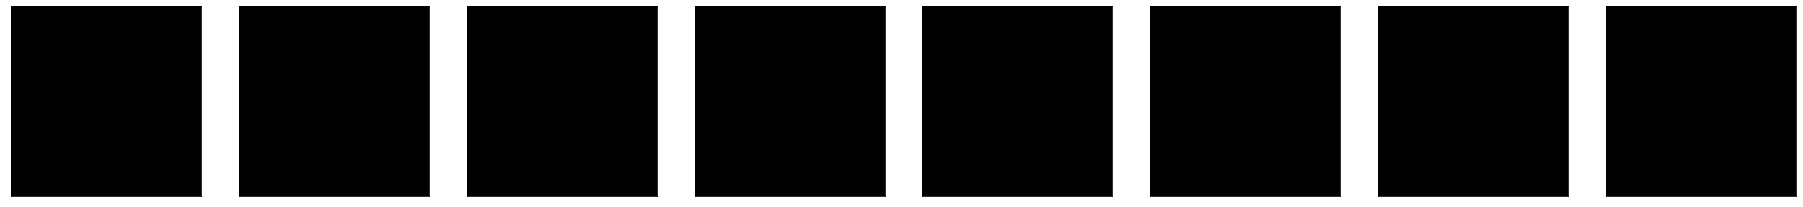

In [12]:
plot_images(best_images)

In [13]:
i, test_batch = next(enumerate(validation_loader))
noisy, clean = test_batch

In [14]:
simple_output = model(noisy,st)

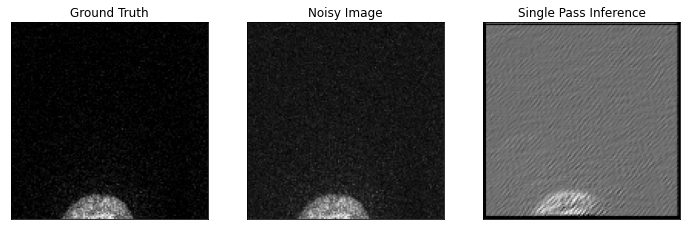

In [15]:
idx = 1
plot_tensors([clean[idx], noisy[idx], simple_output[1][idx]],
            ["Ground Truth", "Noisy Image", "Single Pass Inference"])

## RIM with J-Invariant Mask

In [23]:
from mask_RIM import Masker
masker = Masker(width = 4, mode='interpolate')

data_loader = train_loader

#noisy, clean = noisy_data_train[0];
#net_input, mask = masker.mask(noisy.unsqueeze(0), 0);

losses = []
val_losses = []
best_images = []
best_val_loss = 1



for i, batch in enumerate(data_loader):

    noisy_images, clean_images = batch
    
    model.train()
 
    net_input, mask = masker.mask(noisy_images, i)
    #net_input = noisy_images
    
    if i == 0:
        st = torch.zeros(net_input.size())
        

    net_output, st = model(net_input,st)

        
    loss = loss_function(net_output*mask, noisy_images*mask)
    #loss = loss_function(net_output, noisy_images)
    
    optimizer.zero_grad()
 
    loss.backward(retain_graph=True)
    
    optimizer.step()

    losses.append(loss.item())
    model.eval()


    val_loss = loss_function(net_output*mask, noisy_images*mask)

    val_losses.append(val_loss.item())



    print("Loss (", i, "): \t", round(loss.item(), 4))
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        denoised = np.clip(model(noisy_images,st)[0].detach().numpy()[0, 0], 0, 1).astype(np.float64)
        clean=np.clip(clean_images.detach().cpu().numpy()[0, 0], 0, 1).astype(np.float64)
        best_psnr = compare_psnr(denoised, clean)
        best_images.append(denoised)
        print("\tModel PSNR: ", np.round(best_psnr, 2))


Loss ( 0 ): 	 0.0004


/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:57: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


	Model PSNR:  26.01
Loss ( 1 ): 	 0.002
Loss ( 2 ): 	 0.0003
	Model PSNR:  31.12
Loss ( 3 ): 	 0.0002
	Model PSNR:  33.52
Loss ( 4 ): 	 0.0011
Loss ( 5 ): 	 0.0003
Loss ( 6 ): 	 0.0009
Loss ( 7 ): 	 0.001
Loss ( 8 ): 	 0.0002
	Model PSNR:  33.42
Loss ( 9 ): 	 0.0005
Loss ( 10 ): 	 0.0015
Loss ( 11 ): 	 0.0003
Loss ( 12 ): 	 0.0002
Loss ( 13 ): 	 0.0003
Loss ( 14 ): 	 0.0007
Loss ( 15 ): 	 0.0014


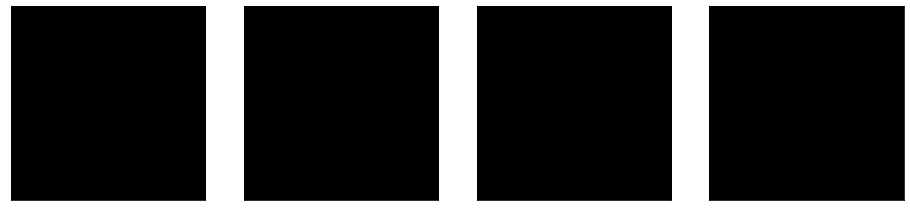

In [39]:
plot_images(best_images)

In [25]:
i, test_batch = next(enumerate(validation_loader))
noisy, clean = test_batch

In [26]:
simple_output = model(noisy,st)
invariant_output = masker.infer_full_image(noisy, model,st)

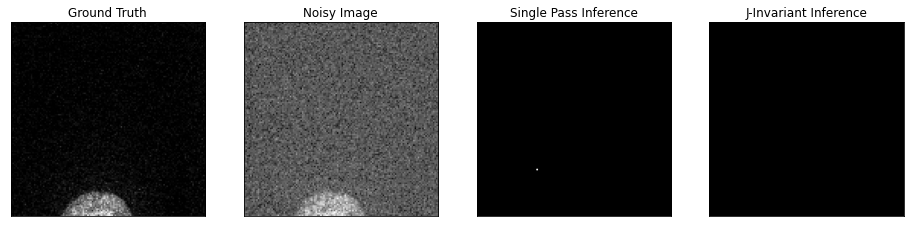

In [29]:
idx = 1
plot_tensors([clean[idx], noisy[idx], simple_output[1][idx], invariant_output[idx]],
            ["Ground Truth", "Noisy Image", "Single Pass Inference", "J-Invariant Inference"])

In [28]:
print("Test loss, single pass: ", round(loss_function(clean, simple_output[0]).item(), 3))
print("Test loss, J-invariant: ", round(loss_function(clean, invariant_output).item(), 3))

Test loss, single pass:  0.002
Test loss, J-invariant:  0.002


## BABY UNET COMPARISON

In [13]:
from mask import Masker
masker = Masker(width = 4, mode='interpolate')

data_loader = train_loader

#noisy, clean = noisy_data_train[0];
#net_input, mask = masker.mask(noisy.unsqueeze(0), 0);

losses = []
val_losses = []
best_images = []
best_val_loss = 1



for i, batch in enumerate(data_loader):

    noisy_images, clean_images = batch
    
    model2.train()
 
    net_input, mask = masker.mask(noisy_images, i)
    #net_input = noisy_images
    
    net_output = model2(net_input)

        
    loss = loss_function(net_output*mask, noisy_images*mask)
    #loss = loss_function(net_output, noisy_images)
    
    optimizer.zero_grad()
 
    loss.backward()
    
    optimizer.step()

    losses.append(loss.item())
    model2.eval()
    

    val_loss = loss_function(net_output*mask, noisy_images*mask)
    #val_loss = net_output

    val_losses.append(val_loss.item())



    print("Loss (", i, "): \t", round(loss.item(), 4))
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        denoised = np.clip(model2(noisy_images).detach().cpu().numpy()[0, 0], 0, 1).astype(np.float64)
        clean=np.clip(clean_images.detach().cpu().numpy()[0, 0], 0, 1).astype(np.float64)
        best_psnr = compare_psnr(denoised, clean)
        best_images.append(denoised)
        print("\tModel PSNR: ", np.round(best_psnr, 2))


Loss ( 0 ): 	 0.2868


/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/ipykernel_launcher.py:54: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


	Model PSNR:  10.97
Loss ( 1 ): 	 0.254
	Model PSNR:  11.34
Loss ( 2 ): 	 0.3617
Loss ( 3 ): 	 0.3547
Loss ( 4 ): 	 0.2578
Loss ( 5 ): 	 0.3249
Loss ( 6 ): 	 0.2731
Loss ( 7 ): 	 0.2564
Loss ( 8 ): 	 0.3511
Loss ( 9 ): 	 0.2933
Loss ( 10 ): 	 0.255
Loss ( 11 ): 	 0.2712
Loss ( 12 ): 	 0.3509
Loss ( 13 ): 	 0.3463
Loss ( 14 ): 	 0.2794
Loss ( 15 ): 	 0.256


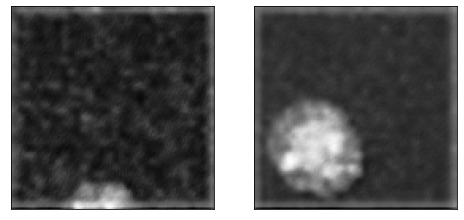

In [14]:
plot_images(best_images)

In [15]:
i, test_batch = next(enumerate(validation_loader))
noisy, clean = test_batch

from mask import Masker

simple_output = model2(noisy)
invariant_output = masker.infer_full_image(noisy, model2)

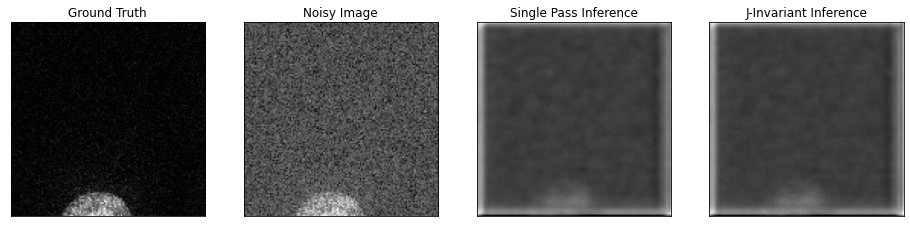

In [16]:
idx = 3
plot_tensors([clean[idx], noisy[idx], simple_output[idx], invariant_output[idx]],
            ["Ground Truth", "Noisy Image", "Single Pass Inference", "J-Invariant Inference"])

In [17]:
print("Test loss, single pass: ", round(loss_function(clean, simple_output[0]).item(), 3))
print("Test loss, J-invariant: ", round(loss_function(clean, invariant_output).item(), 3))

Test loss, single pass:  0.181
Test loss, J-invariant:  0.18


/wynton/home/huang/emaad/.local/lib/python3.6/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 128, 128])) that is different to the input size (torch.Size([50, 1, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
